In [1]:
import warnings
warnings.filterwarnings("ignore")
import MENDER
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import *
import time

import pysodb
from sklearn import svm

In [2]:
sodb = pysodb.SODB()
adata_raw = sodb.load_experiment('codeluppi2018spatial','cortex')

load experiment[cortex] in dataset[codeluppi2018spatial]


In [3]:
# remove invalid cells
adata_raw = adata_raw[adata_raw.obs['Region']!='Excluded']

In [4]:
gt_obs = 'Region'

In [5]:
# input parameters of MENDER
scale = 6

# radius is set to 150 not 15, because the unit of the spatial coordination is 0.1 um for this data, as suggested by estimate_radius
radius = 150

n_domains = len(adata_raw.obs['Region'].cat.categories)
print(n_domains)
# record running time
time_st = time.time()


adata = adata_raw.copy()



######### determine cell state using standard Leiden [start]  #########
# this step can be optionally skipped if reliable cell type annotation is available
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata,resolution=2,key_added='ct',random_state=666)
adata.obs['ct'] = adata.obs['ct'].astype('category')
######### determine cell state using standard Leiden [end]  #########


# main body of MENDER
msm = MENDER.MENDER_single(
    adata,
    # determine which cell state to use
    # we use the cell state got by Leiden
    # ct_obs='ct',

    random_seed=666
)


# set the MENDER parameters


msm.set_MENDER_para(
    # default of n_scales is 6
    n_scales=scale,

    # for single cell data, nn_mode is set to 'radius'
    nn_mode='radius',

    # default of n_scales is 15 um (see the manuscript for why).
    # MENDER also provide a function 'estimate_radius' for estimating the radius
    nn_para=radius,

)
# construct the context representation
msm.run_representation(
    # the number of processings
    # 8
)

# set the spatial clustering parameter
# positive values for the expected number of domains
# negative values for the clustering resolution
msm.run_clustering_normal(n_domains)

time_ed = time.time()
time_cost = time_ed-time_st

11
scale 0, median #cells per radius (r=150): 1.0
scale 1, median #cells per radius (r=150): 2.0
scale 2, median #cells per radius (r=150): 3.0
scale 3, median #cells per radius (r=150): 4.0
scale 4, median #cells per radius (r=150): 5.0
scale 5, median #cells per radius (r=150): 6.0
searching resolution to k=11
Res =  0.1 Num of clusters =  5
Res =  0.15000000000000002 Num of clusters =  7
Res changed to 0.15000000000000002
Res =  0.2 Num of clusters =  7
Res changed to 0.2
Res =  0.25 Num of clusters =  8
Res changed to 0.25
Res =  0.3 Num of clusters =  8
Res changed to 0.3
Res =  0.35 Num of clusters =  8
Res changed to 0.35
Res =  0.39999999999999997 Num of clusters =  8
Res changed to 0.39999999999999997
Res =  0.44999999999999996 Num of clusters =  9
Res changed to 0.44999999999999996
Res =  0.49999999999999994 Num of clusters =  10
Res changed to 0.49999999999999994
Res =  0.5499999999999999 Num of clusters =  11
recommended res =  0.5499999999999999


In [6]:
y = adata_raw.obs['ClusterName'].astype('category')


In [7]:
from sklearn.cross_decomposition import CCA

# CCA
matrix1 = msm.adata.obsm['whole']
matrix2 = adata_raw.X

cca = CCA(n_components=33)
cca.fit(matrix1, matrix2)


matrix1_c, matrix2_c = cca.transform(matrix1, matrix2)
cca_concat = np.hstack([matrix1_c, matrix2_c])

In [8]:
X_cca = cca_concat
X_gene = adata_raw.X
X_mender = msm.adata.obsm['whole']

In [9]:
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

lsvc = svm.LinearSVC(random_state=42)

y_pred_cca_lsvc = cross_val_predict(lsvc, X_cca, y, cv=cv)
y_pred_mender_lsvc = cross_val_predict(lsvc, X_mender, y, cv=cv)
y_pred_gene_lsvc = cross_val_predict(lsvc, X_gene, y, cv=cv)

rbf_svc = svm.SVC(kernel='rbf', random_state=42)

y_pred_cca_rbf = cross_val_predict(rbf_svc, X_cca, y, cv=cv)
y_pred_mender_rbf = cross_val_predict(rbf_svc, X_mender, y, cv=cv)
y_pred_gene_rbf = cross_val_predict(rbf_svc, X_gene, y, cv=cv)

random_forest = RandomForestClassifier(max_depth=None, random_state=42)

y_pred_cca_rf = cross_val_predict(random_forest, X_cca, y, cv=cv)
y_pred_mender_rf = cross_val_predict(random_forest, X_mender, y, cv=cv)
y_pred_gene_rf = cross_val_predict(random_forest, X_gene, y, cv=cv)

In [11]:
msm.adata_MENDER.obs['true_label'] = y

msm.adata_MENDER.obs[f'pred_label_cca_lsvc'] = y_pred_cca_lsvc
msm.adata_MENDER.obs[f'pred_label_mender_lsvc'] = y_pred_mender_lsvc
msm.adata_MENDER.obs[f'pred_label_gene_lsvc'] = y_pred_gene_lsvc

msm.adata_MENDER.obs[f'pred_label_cca_rbf'] = y_pred_cca_rbf
msm.adata_MENDER.obs[f'pred_label_mender_rbf'] = y_pred_mender_rbf
msm.adata_MENDER.obs[f'pred_label_gene_rbf'] = y_pred_gene_rbf

msm.adata_MENDER.obs[f'pred_label_cca_rf'] = y_pred_cca_rf
msm.adata_MENDER.obs[f'pred_label_mender_rf'] = y_pred_mender_rf
msm.adata_MENDER.obs[f'pred_label_gene_rf'] = y_pred_gene_rf


In [12]:
for clf in ['lsvc', 'rbf', 'rf']:
    for rep in ['gene', 'mender', 'cca']:
        msm.adata_MENDER.obs[f'correct_{rep}_{clf}'] = (msm.adata_MENDER.obs['true_label'] == msm.adata_MENDER.obs[f'pred_label_{rep}_{clf}'])

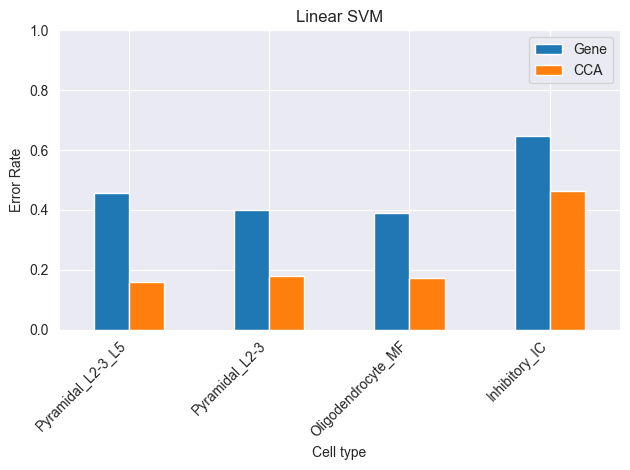

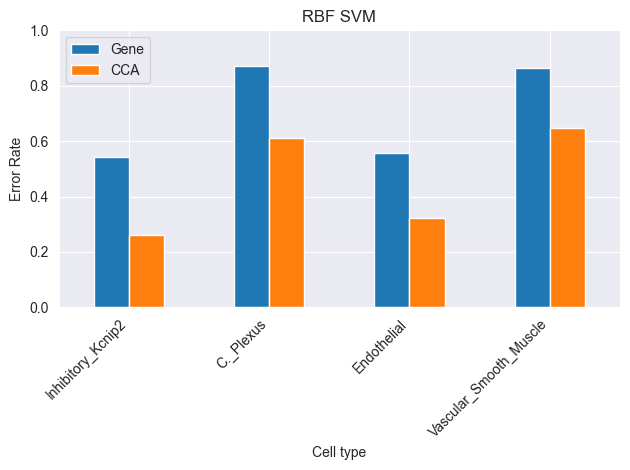

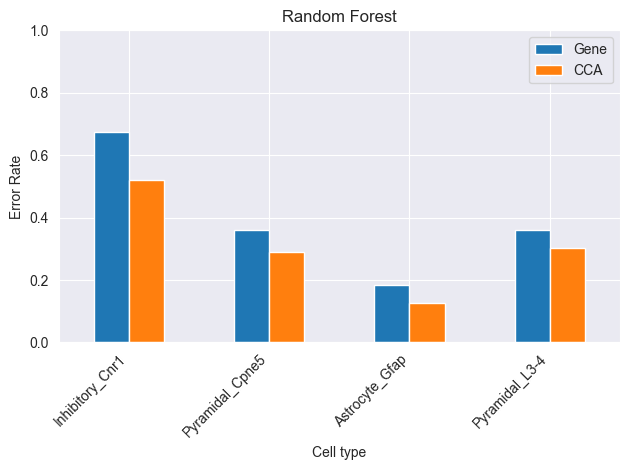

In [13]:
import matplotlib.pyplot as plt

grouping_key = 'ClusterName'
plot_extra_name = "per cell type"
top_n = 4

clf_full_names = {
    'lsvc': 'Linear SVM',
    'rbf': 'RBF SVM',
    'rf': 'Random Forest'
}

for clf in ['lsvc', 'rbf', 'rf']:
    # Compute accuracy per cell type
    accuracy = (
        msm.adata_MENDER.obs
        .groupby(grouping_key)[[f'correct_gene_{clf}', f'correct_cca_{clf}']]
        .mean()
    )

    error_rates = 1 - accuracy

    # calculate improvement that cca gives compared to genes
    improvement = error_rates[f'correct_gene_{clf}'] - error_rates[f'correct_cca_{clf}']

    # find the cell types where cca helped the most
    top_groups_cell_type = improvement.sort_values(ascending=False).head(top_n).index

    plot_data = error_rates.loc[top_groups_cell_type, [f'correct_gene_{clf}', f'correct_cca_{clf}']]
    plot_data.columns = ['Gene', 'CCA']

    # Plot
    plot_data.plot(kind='bar')
    plt.ylabel("Error Rate")
    plt.xlabel("Cell type")
    plt.ylim(0, 1)

    plt.title(f"{clf_full_names[clf]}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Save before showing
    plt.savefig(f"{clf}_{grouping_key}_cca_vs_gene_{top_n}.png", dpi=300, bbox_inches='tight')
    plt.show()
